In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from data_io.loader.data_loader import DataLoader

In [2]:
loader = DataLoader()

# alle Stationen abrufen
stations = loader.get_bicyle_stations()

# alle BicycleData-Objekte laden
tables = [loader.get_bicycle(st) for st in stations]

In [3]:
# generate an array of all channels_all column entries
hourly_data = {}

for bd in tables:
    df = bd.df                      
    station = bd.station            
    
    start_date = df["datetime"][0]
    end_date   = df["datetime"][-1]
    data_all   = df["channels_all"].to_numpy()

    hourly_data[station] = (data_all, start_date, end_date)

for station, (data, start_date, end_date) in hourly_data.items():
    print(f"Station: {station}, Date Range: {start_date} → {end_date}")

Station: Ziegelhäuser Landstraße, Date Range: 2019-07-31 22:00:00+00:00 → 2019-12-31 21:00:00+00:00
Station: Bahnstadtpromenade, Date Range: 2020-08-31 22:00:00+00:00 → 2020-02-29 21:00:00+00:00
Station: Berliner Straße Querschnitt, Date Range: 2024-02-29 23:00:00+00:00 → 2020-02-29 21:00:00+00:00
Station: Gaisbergstraße, Date Range: 2017-09-30 22:00:00+00:00 → 2017-09-30 20:00:00+00:00
Station: Eppelheimer Str. Querschnitt, Date Range: 2024-04-30 22:00:00+00:00 → 2020-02-29 21:00:00+00:00
Station: Kurfürstenanlage Querschnitt, Date Range: 2019-07-31 22:00:00+00:00 → 2019-12-31 21:00:00+00:00
Station: Plöck, Date Range: 2017-09-30 22:00:00+00:00 → 2017-09-30 20:00:00+00:00
Station: Ernst-Walz-Brücke West - alt, Date Range: 2017-09-30 22:00:00+00:00 → 2017-09-30 20:00:00+00:00
Station: Liebermannstraße, Date Range: 2019-07-31 22:00:00+00:00 → 2019-12-31 21:00:00+00:00
Station: Schlierbacher Landstraße, Date Range: 2019-07-31 22:00:00+00:00 → 2019-12-31 21:00:00+00:00
Station: Thedor-Heu

In [4]:
def print_series(data, start_date, end_date, station_name):
    n = len(data)
    x = np.arange(n)

    window = 24 if n >= 24 else max(3, n // 10)
    smoothed = np.convolve(data, np.ones(window) / window, mode='same')

    start_str = start_date.strftime("%Y-%m-%d %H:%M")
    end_str   = end_date.strftime("%Y-%m-%d %H:%M")

    plt.figure(figsize=(25, 5))
    plt.plot(x, data, color='gray', alpha=0.25, linewidth=0.5, label='raw')
    plt.plot(x, smoothed, color='tab:blue', linewidth=1.5, label=f'{window}-hour MA')

    plt.xticks([0, max(n - 1, 0)], [start_str, end_str])

    plt.title(f'Cycle Counter Data for {station_name}\nfrom {start_str} to {end_str}')
    plt.xlabel(f'Hours since {start_str}')
    plt.ylabel('Cycle Counts (All Channels)')
    plt.legend()
    plt.show()


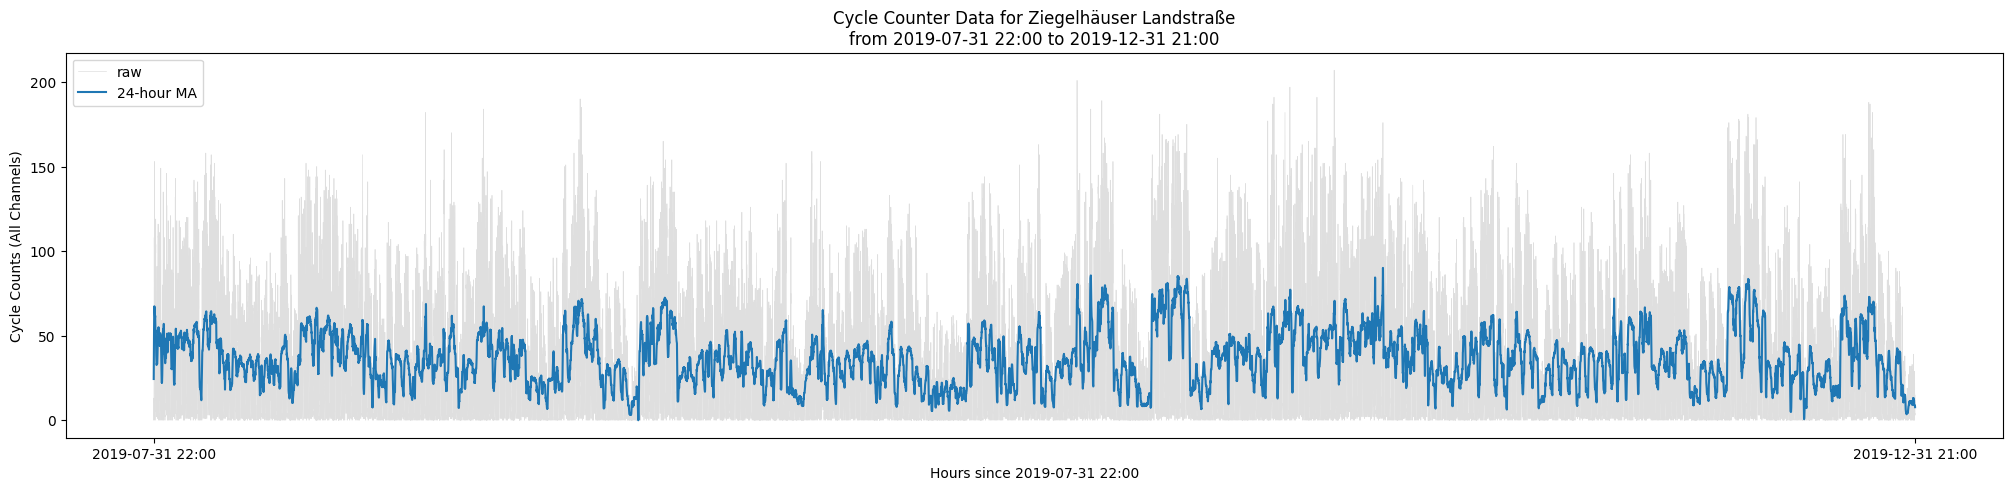

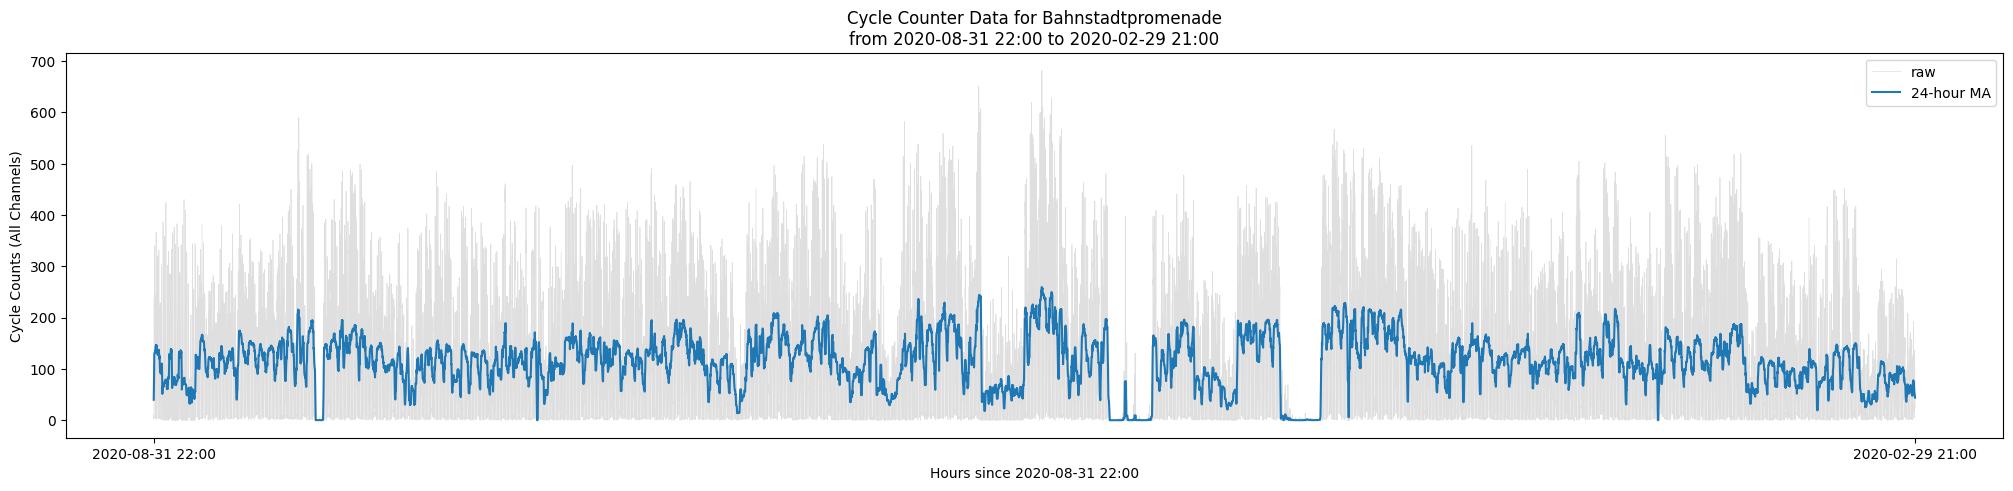

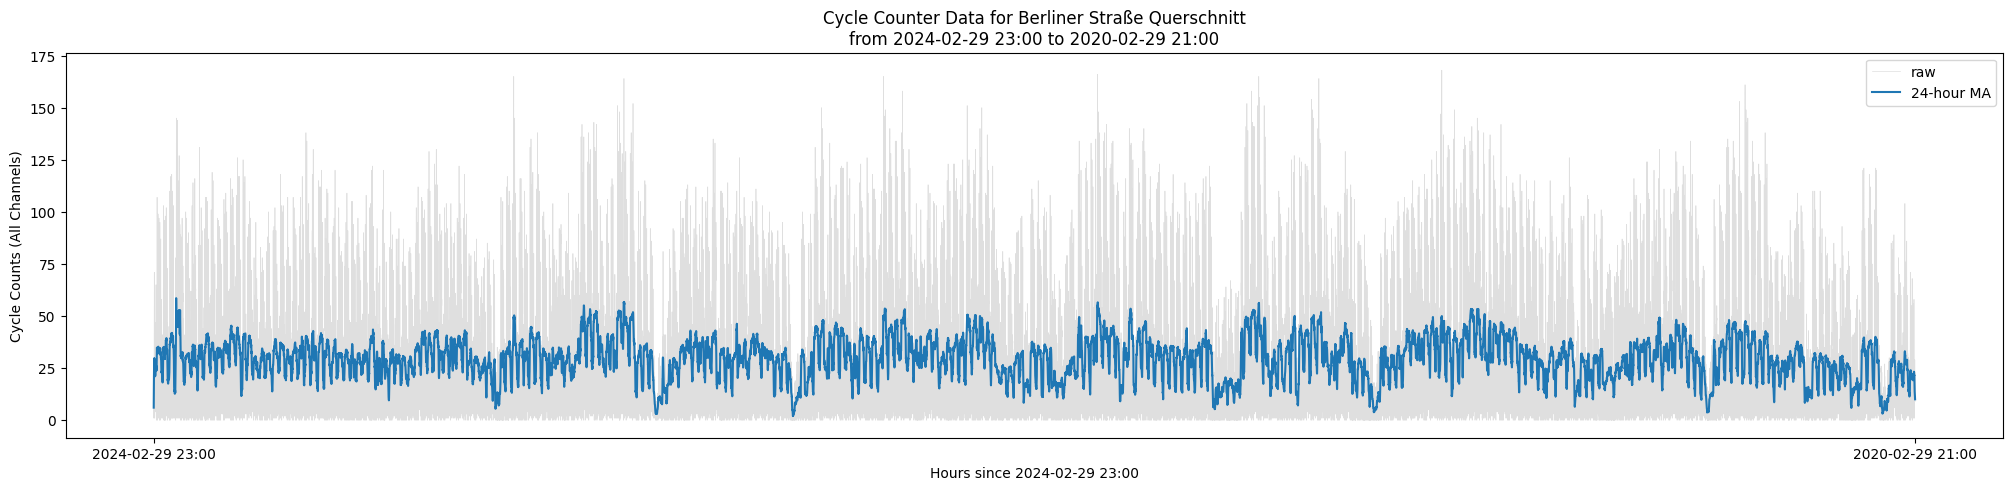

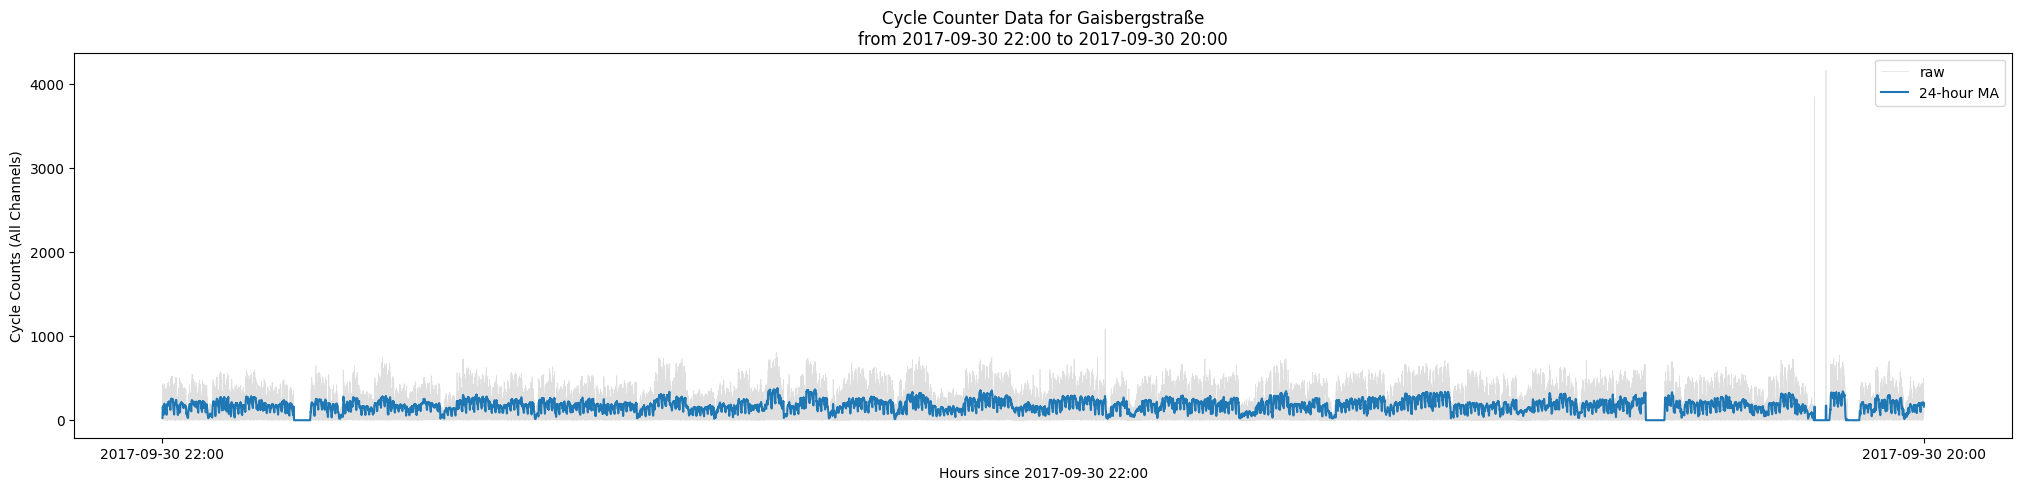

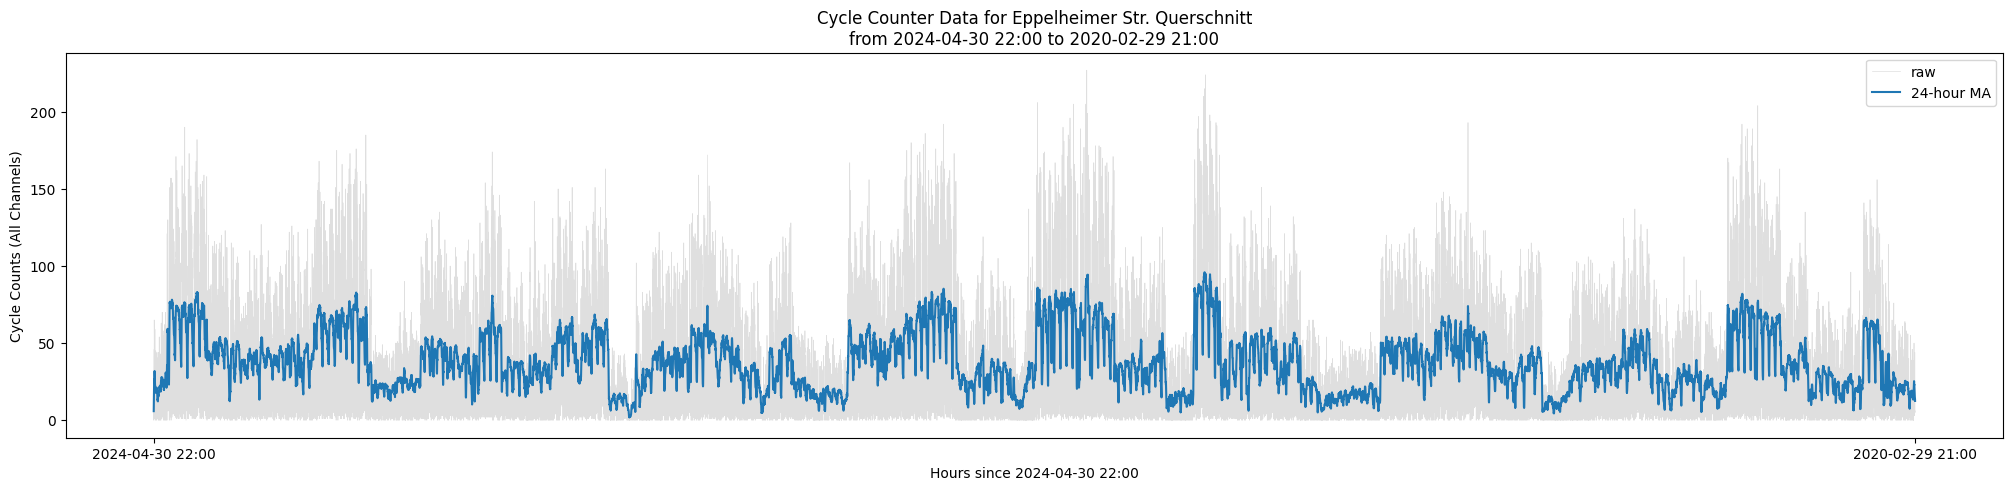

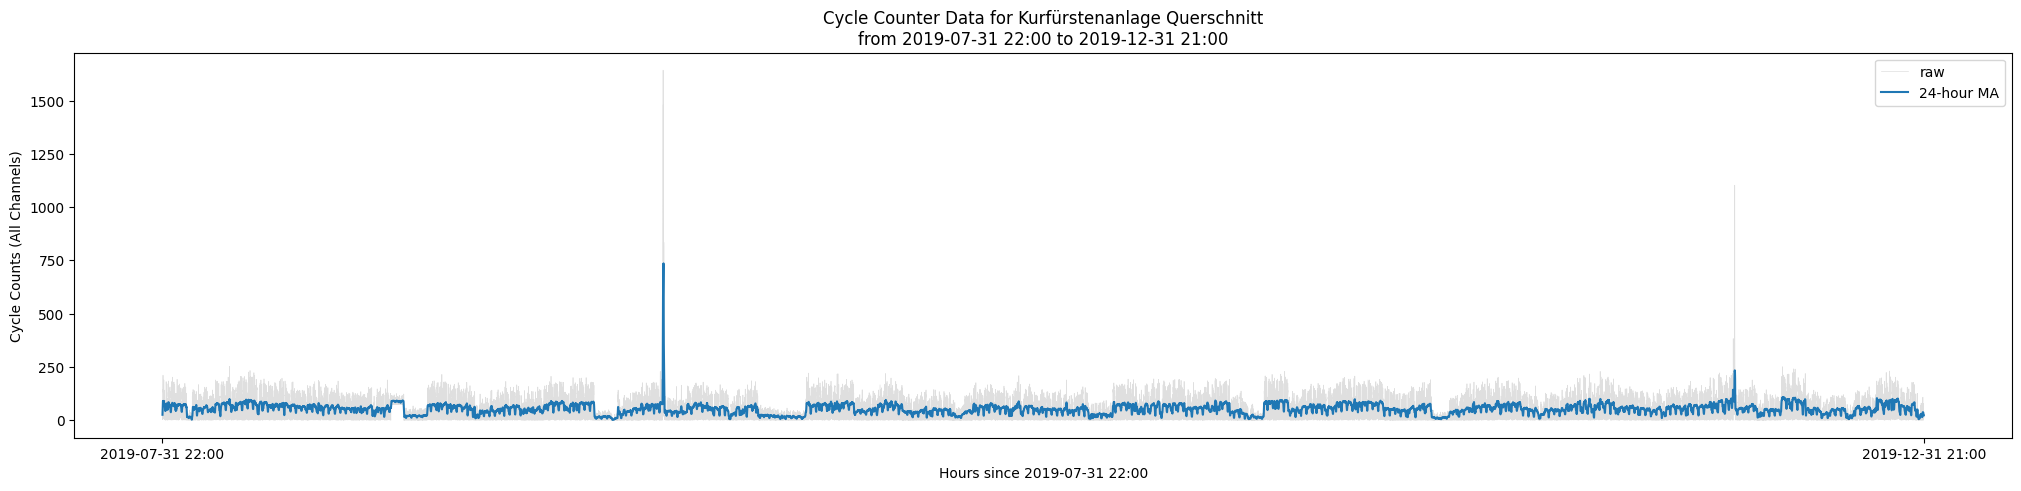

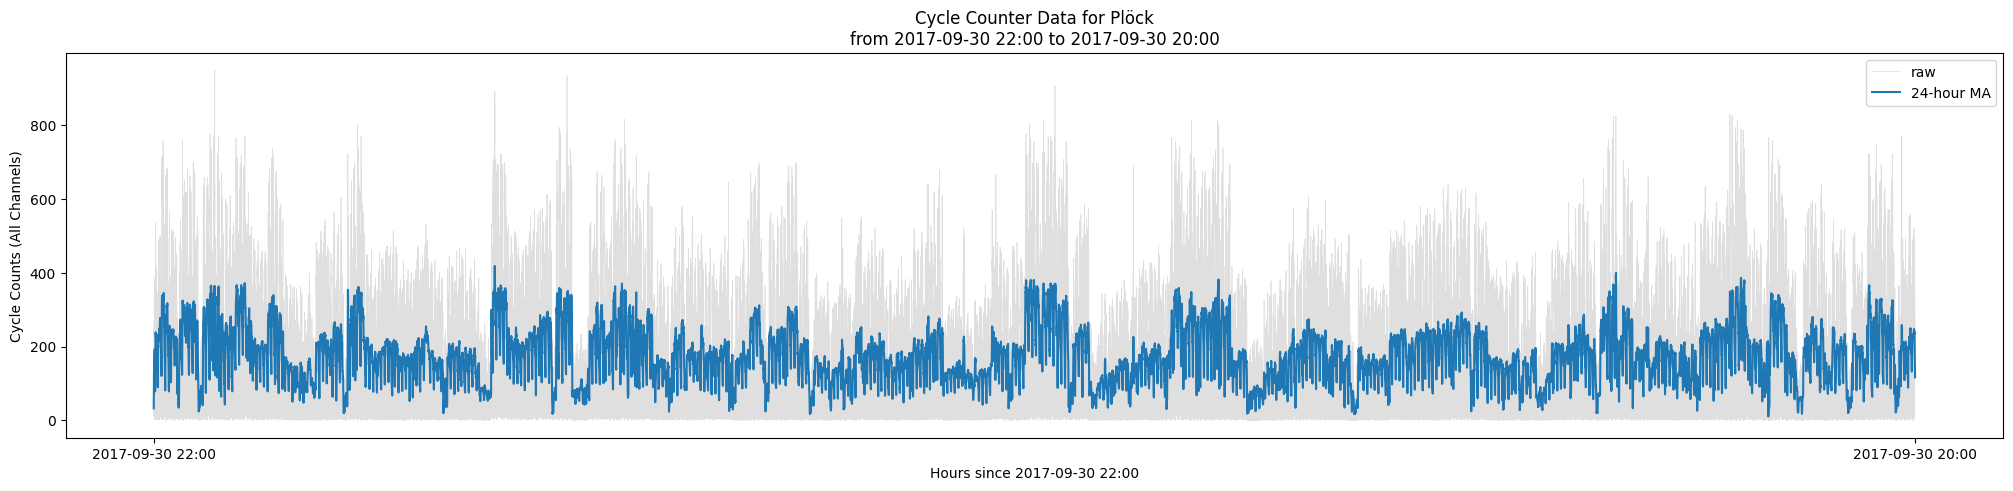

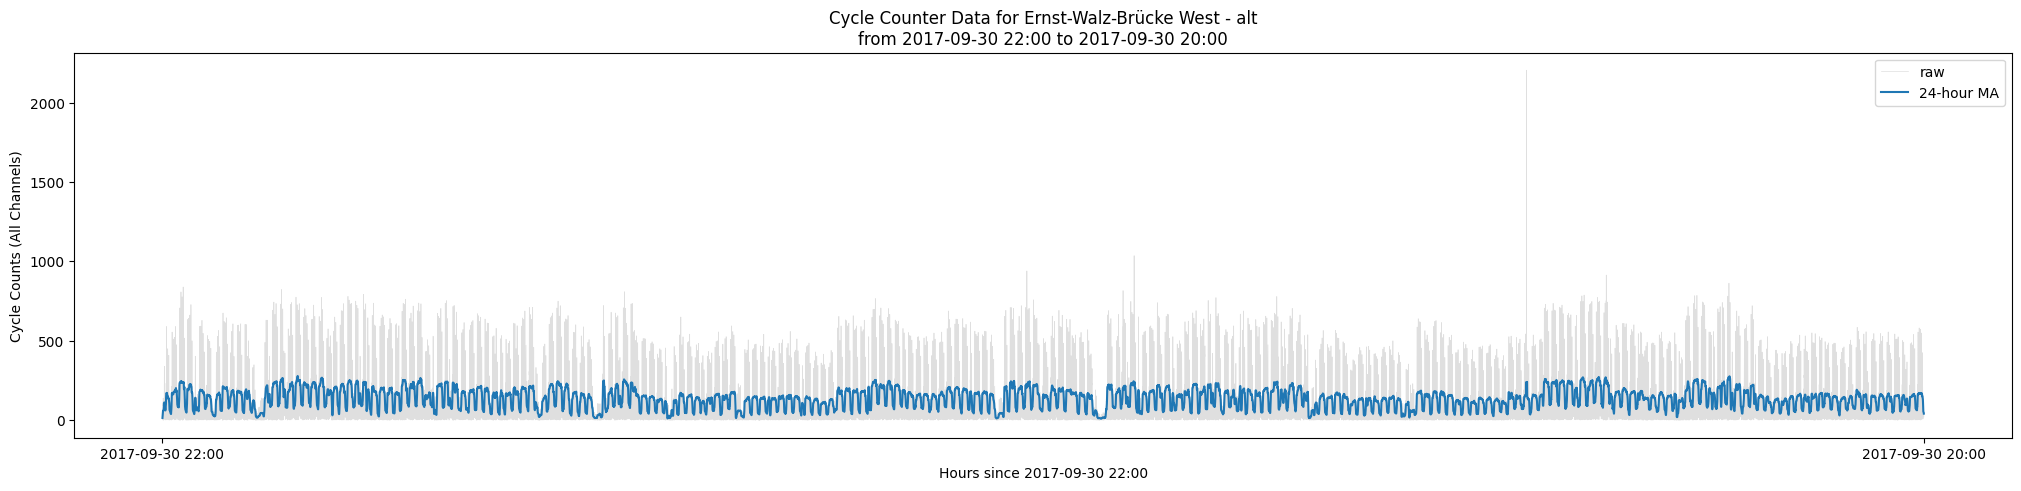

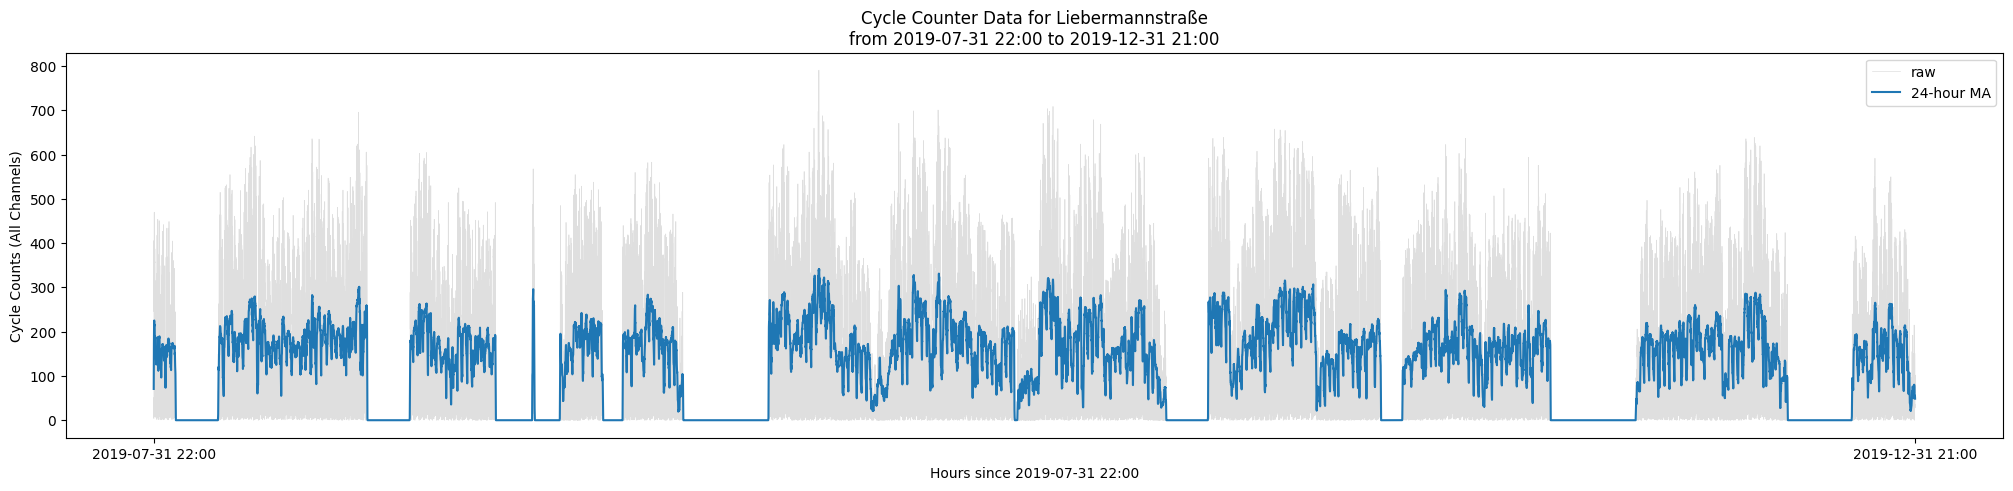

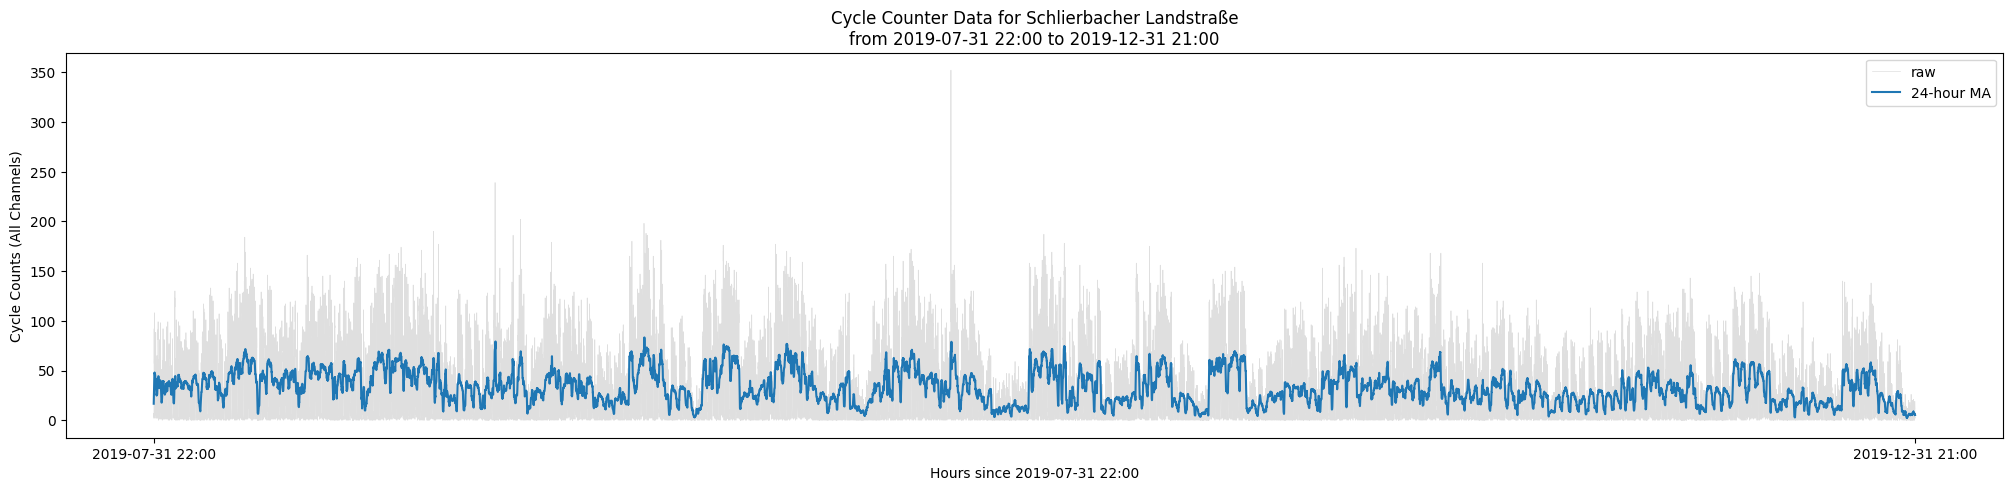

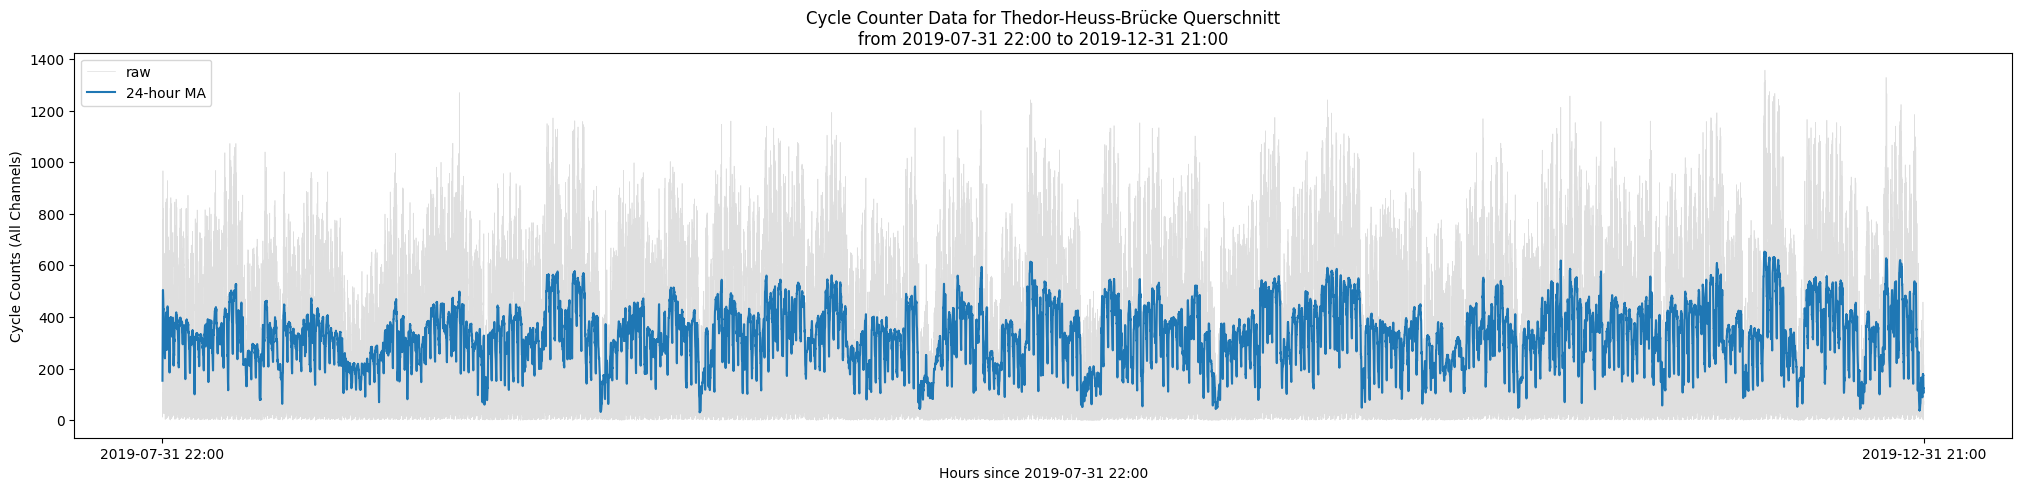

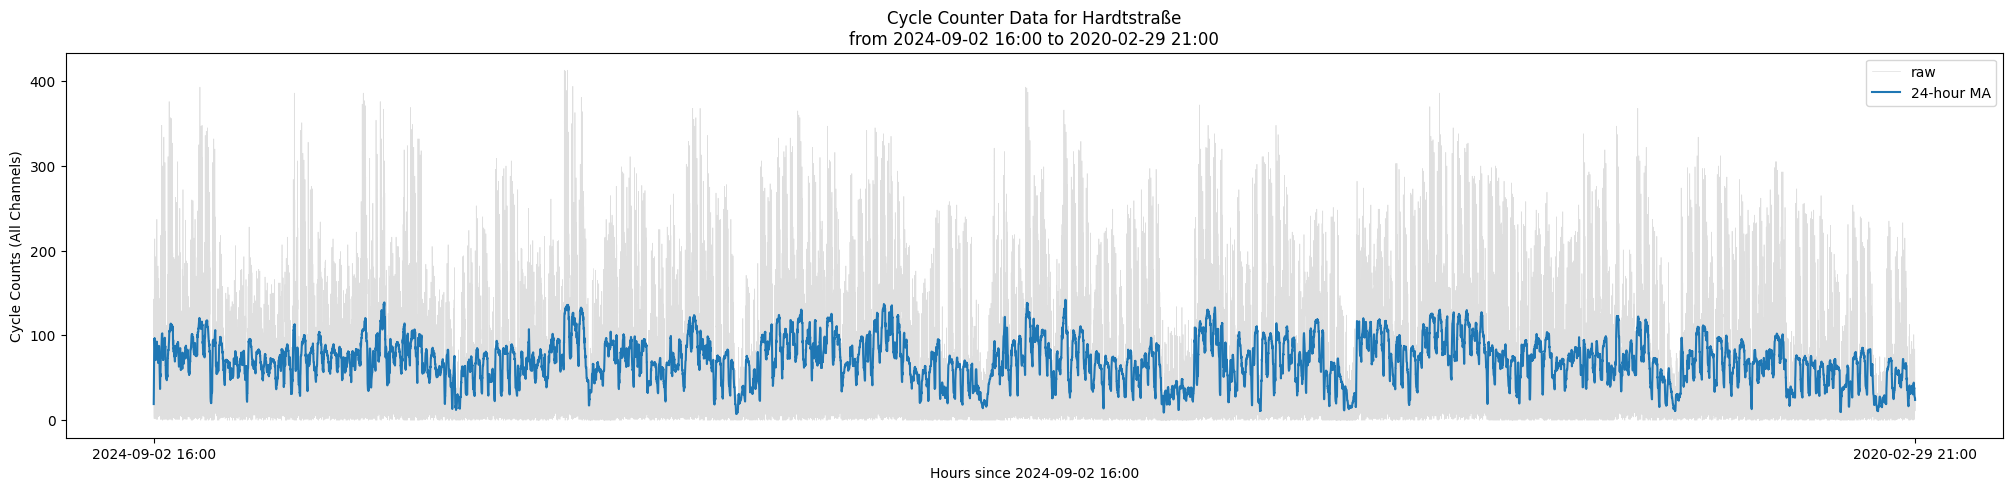

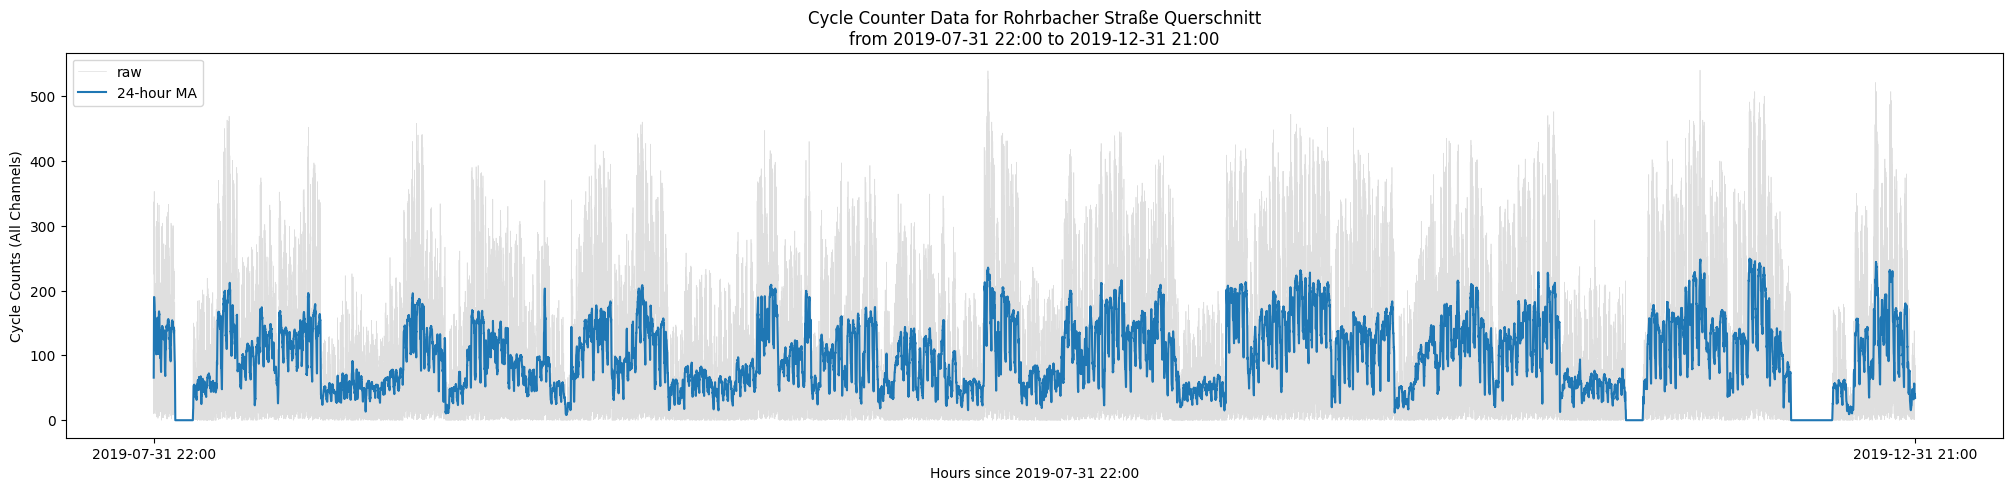

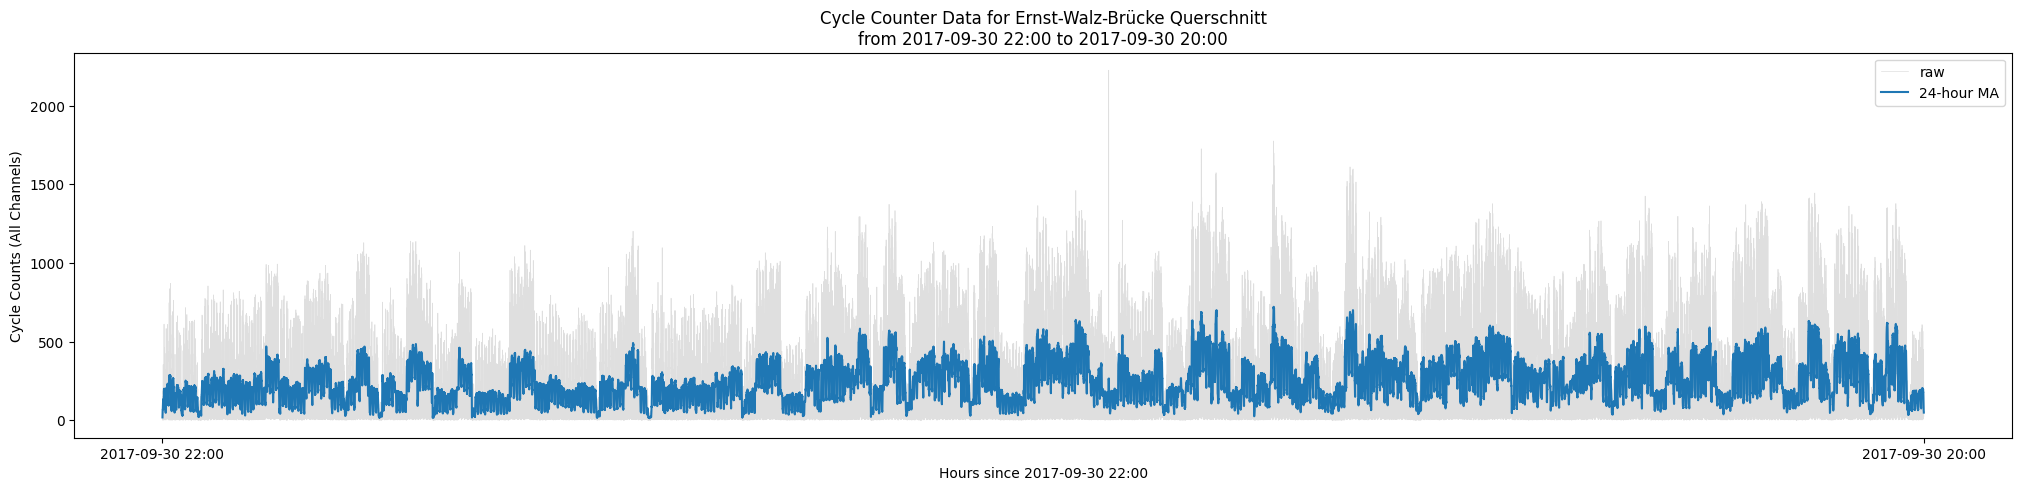

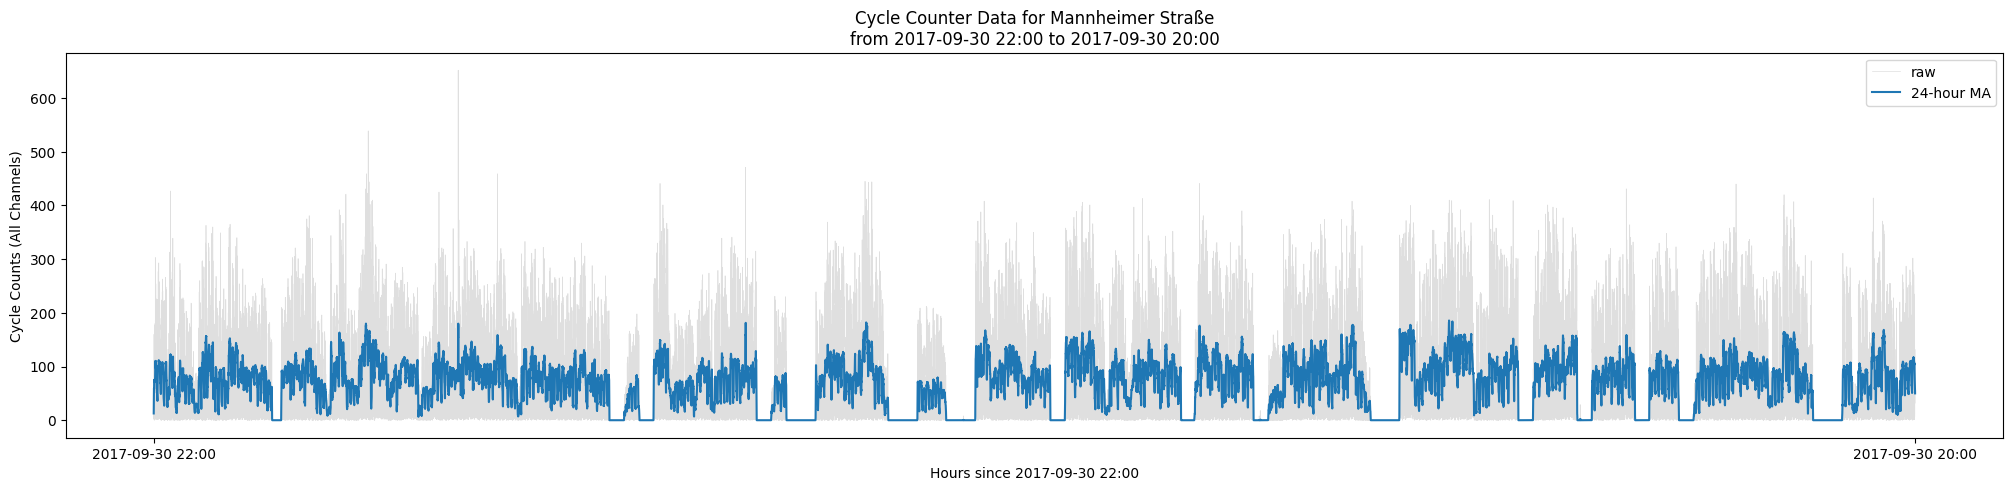

In [5]:
for station_name, (data, start_date, end_date) in hourly_data.items():
    print_series(data, start_date, end_date, station_name)
    

In [6]:

def plot_fft_cycle(data, station_name, start_date, end_date):
    n = len(data)
    timestep = 1  # assuming hourly data, so 1 hour between samples
    freq = np.fft.rfftfreq(n, d=timestep)
    fft_values = np.fft.rfft(data)
    fft_magnitude = np.abs(fft_values)

    start_str = start_date.strftime("%Y-%m-%d %H:%M")
    end_str   = end_date.strftime("%Y-%m-%d %H:%M")

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=freq, y=fft_magnitude, color='tab:blue')
    plt.title(f'FFT of Cycle Counts for {station_name}\nfrom {start_str} to {end_str}')
    plt.xlabel('Frequency (cycles per hour)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

In [7]:
#normalize data before FFT
normalized= {}
for station_name, (data, start_date, end_date) in hourly_data.items():
    data_mean = np.mean(data)
    data_std = np.std(data)
    normalized_data = (data - data_mean) / data_std
    normalized[station_name] = (normalized_data , start_date, end_date)

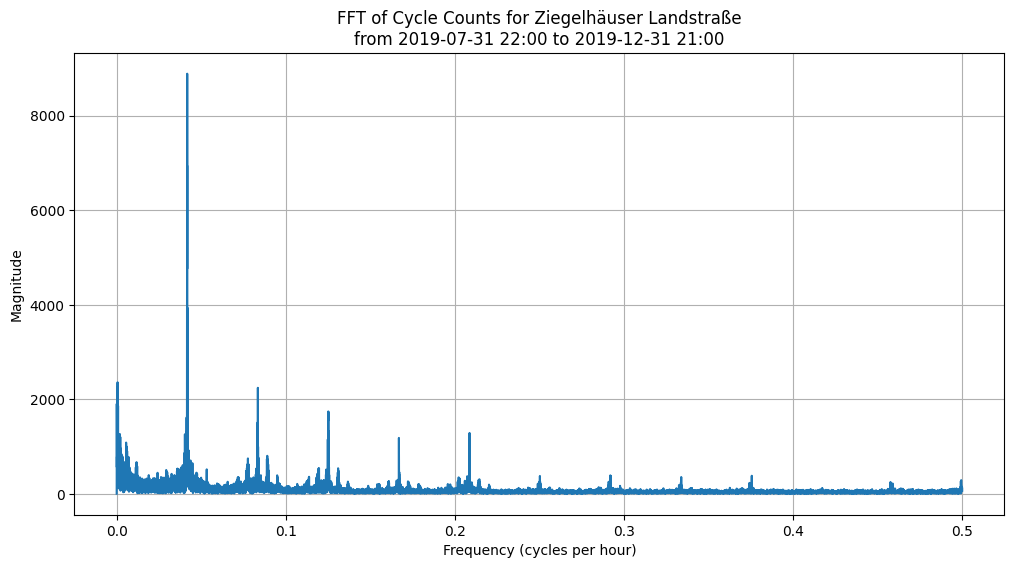

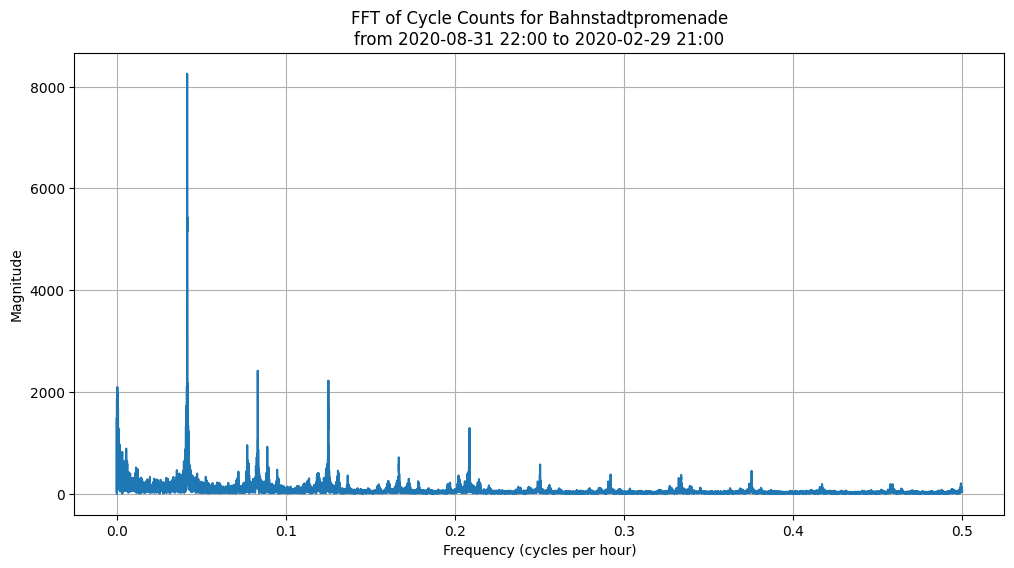

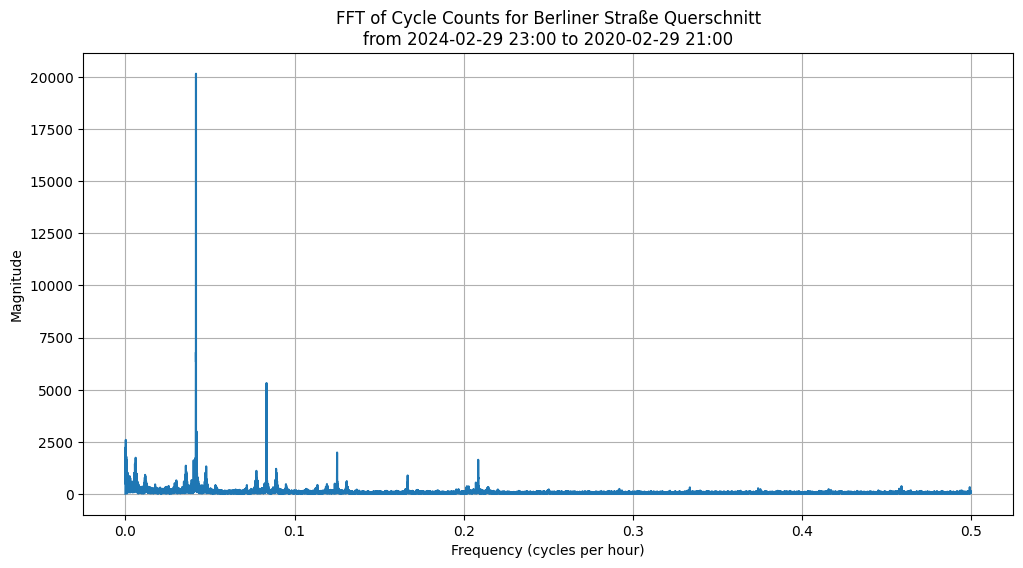

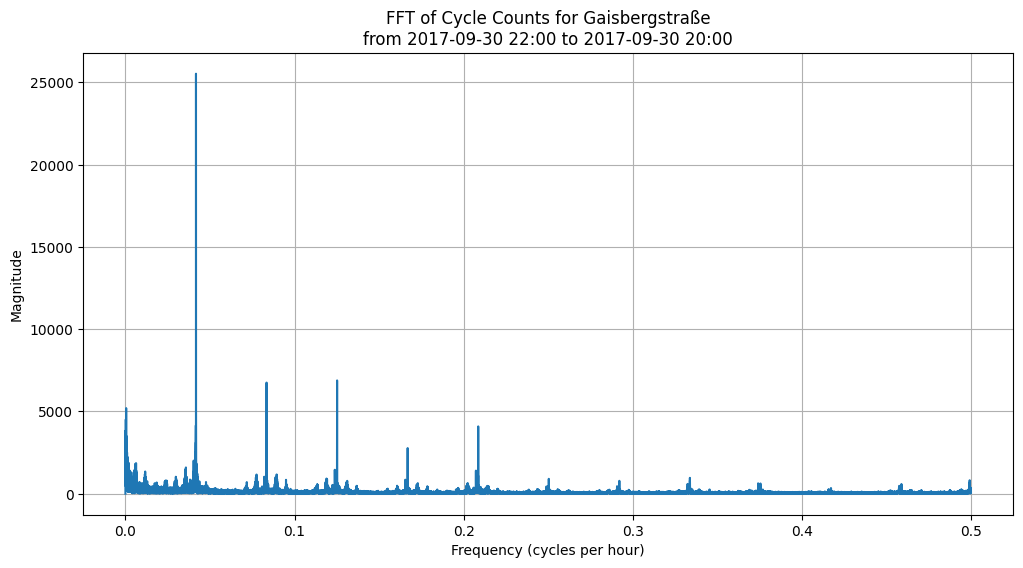

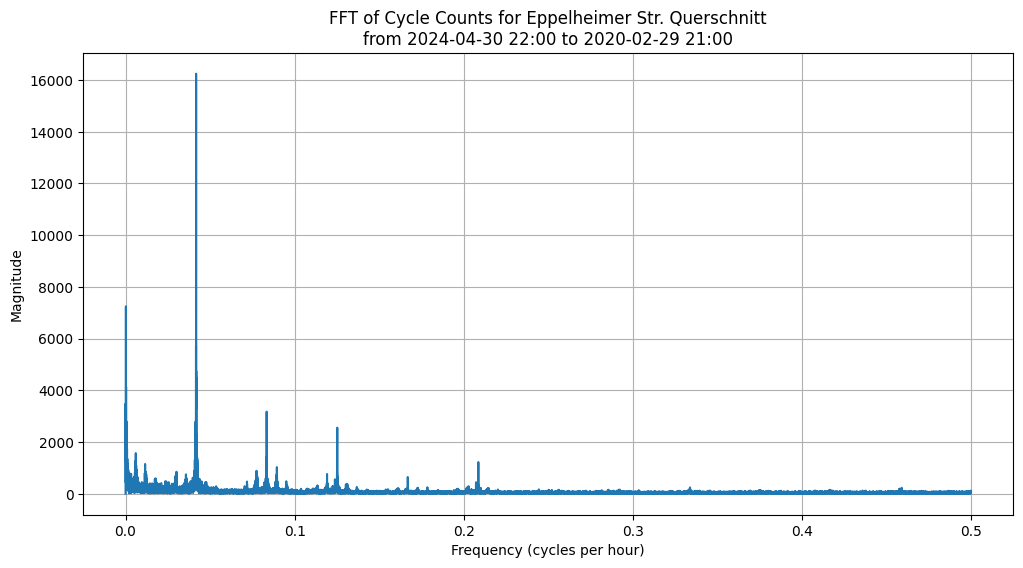

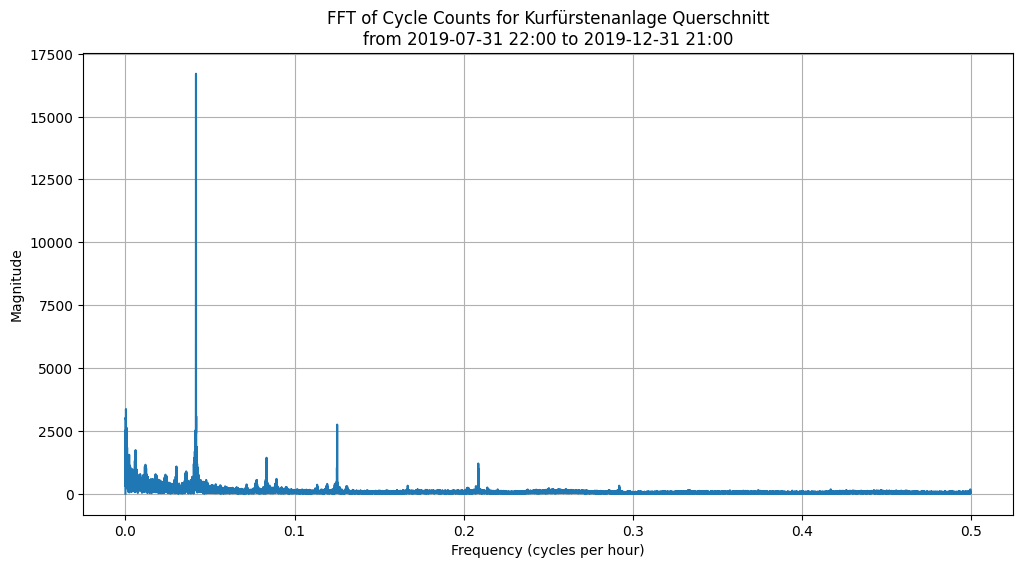

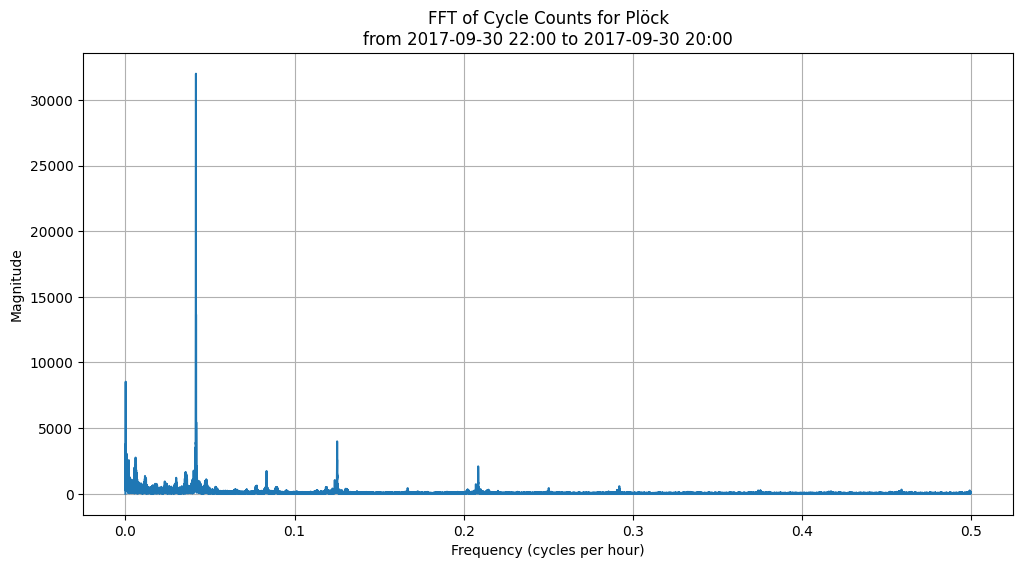

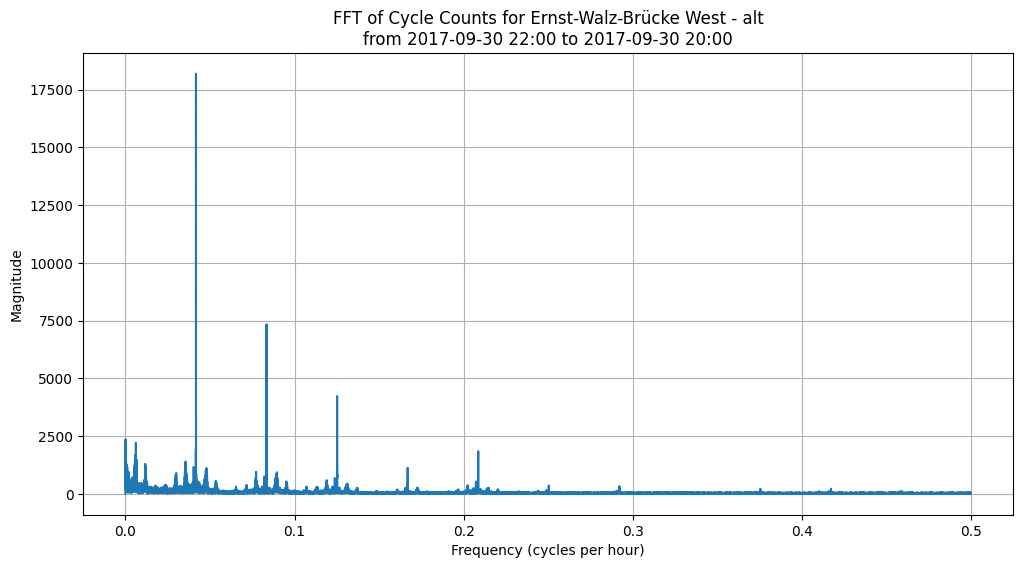

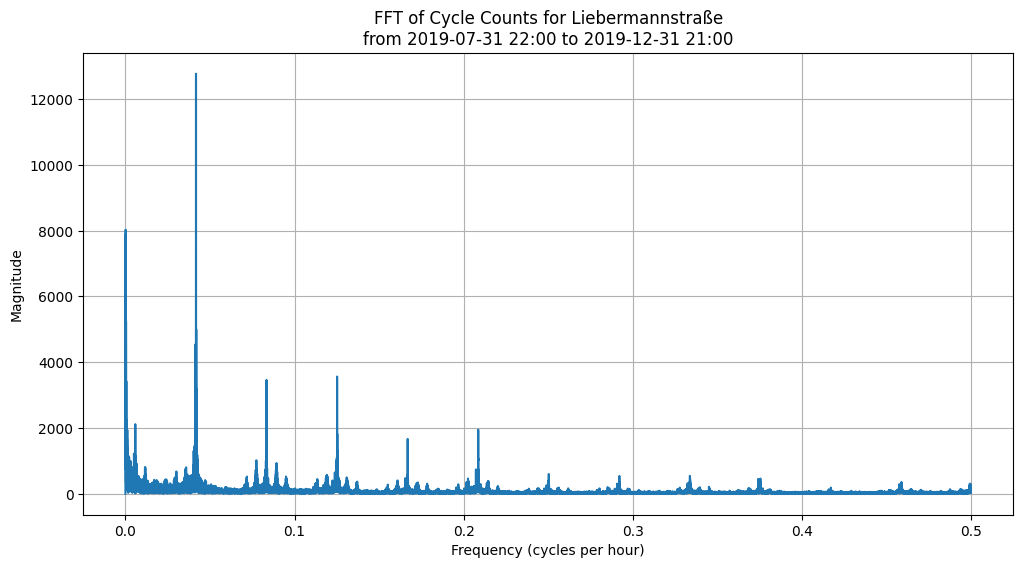

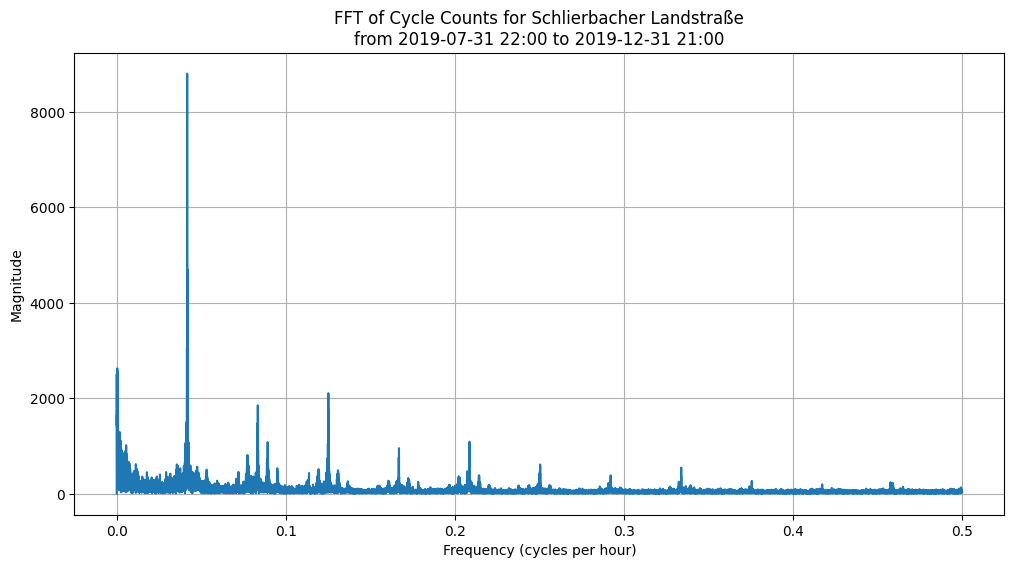

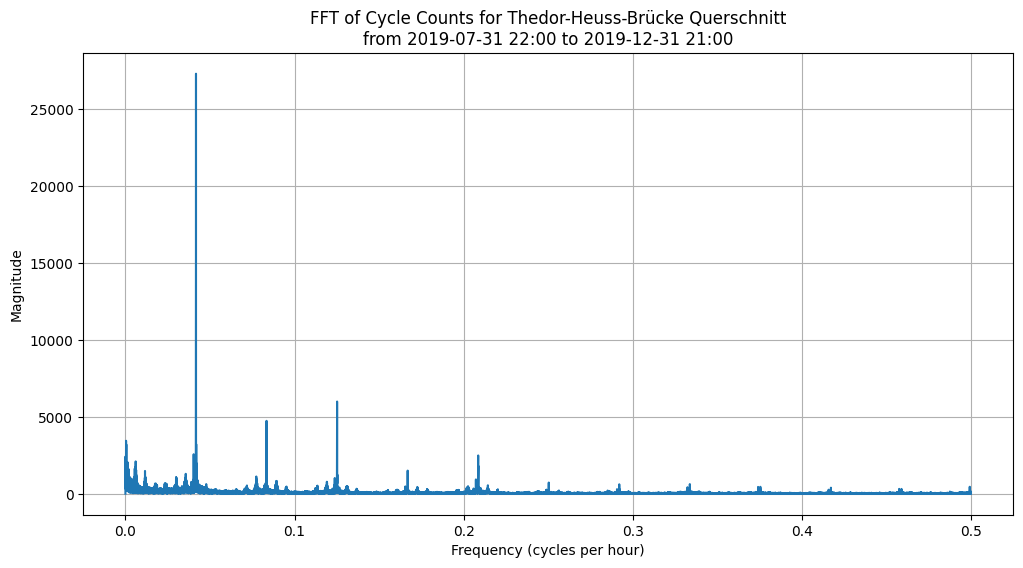

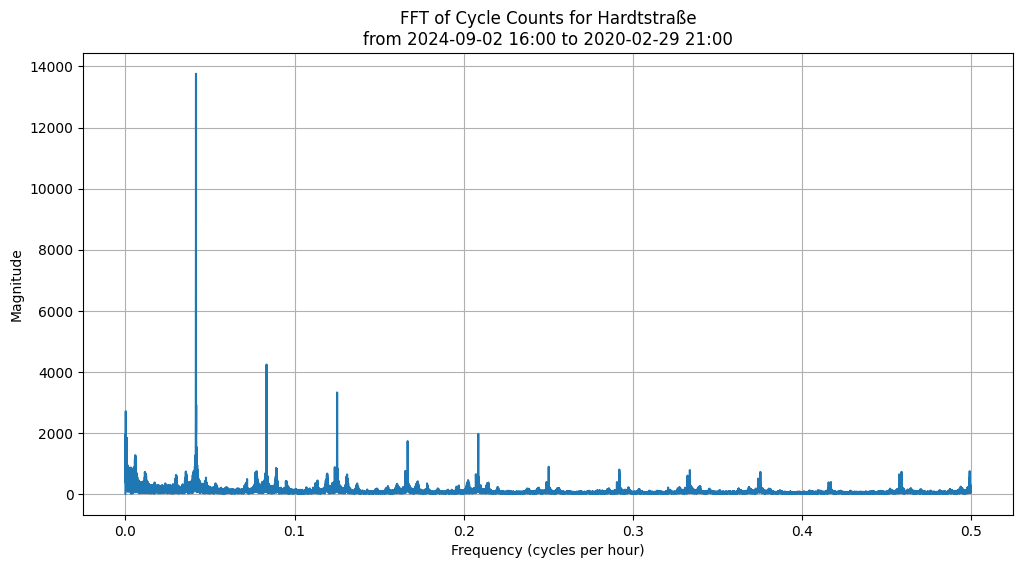

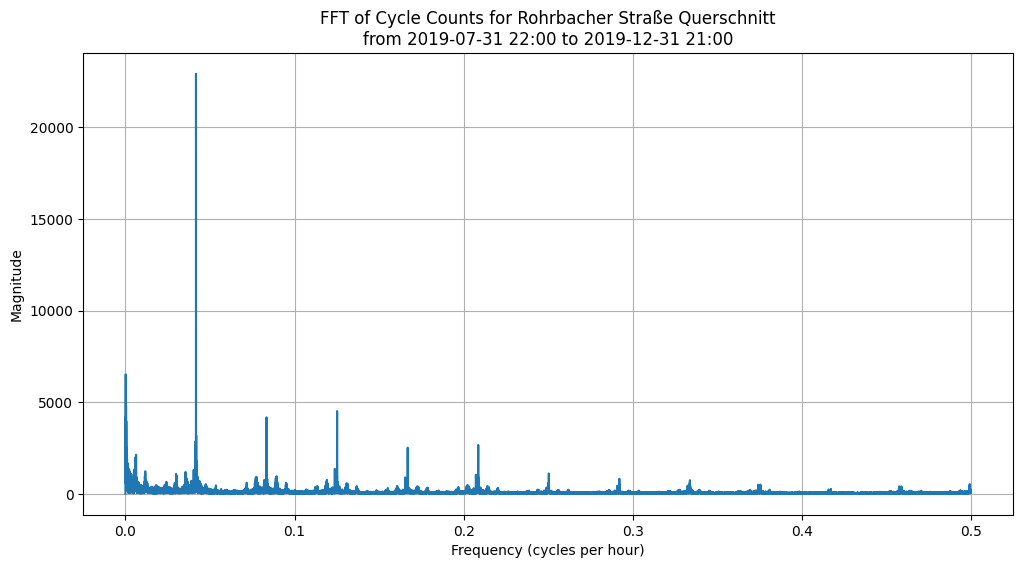

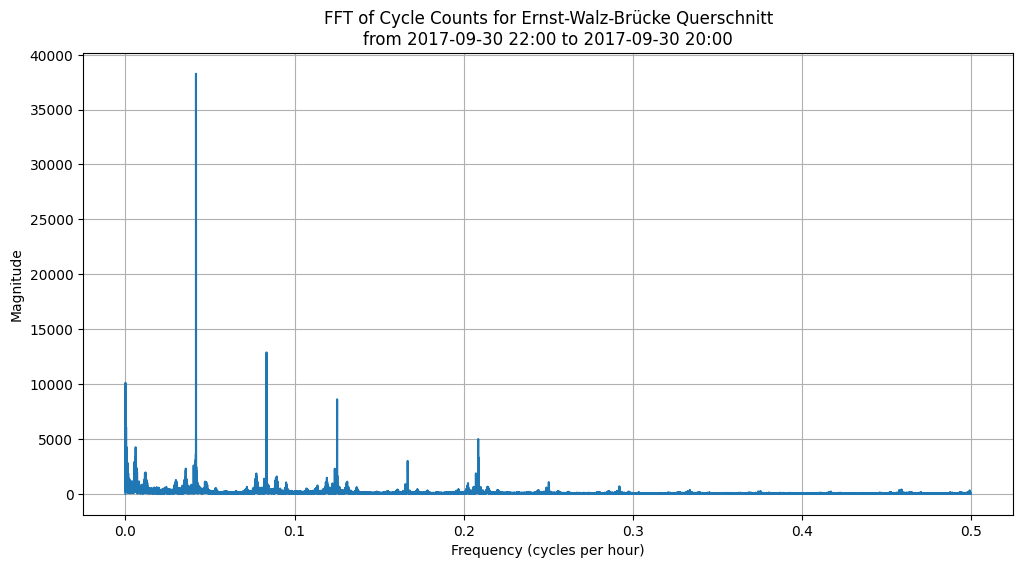

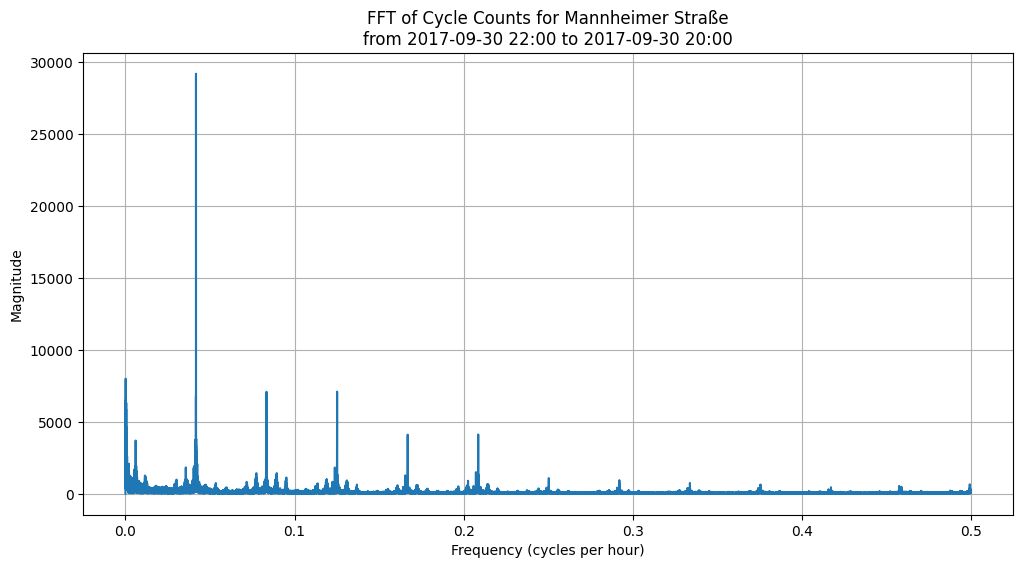

In [8]:
# plot the normalized data
for station_name, (data, start_date, end_date) in normalized.items():
    plot_fft_cycle(data, station_name, start_date, end_date)

In [9]:
# Print dominant frequencies in interpretable format
for station_name, (data, start_date, end_date) in normalized.items():
    n = len(data)
    if n == 0:
        continue
    
    timestep = 1  # hours
    freq = np.fft.rfftfreq(n, d=timestep)
    fft_values = np.fft.rfft(data)
    fft_magnitude = np.abs(fft_values)
    
    # Focus on low frequencies (< 0.5 cycles/hour)
    mask = freq <= 0.5
    freq_filtered = freq[mask]
    mag_filtered = fft_magnitude[mask]
    
    # Get top 10 components (skip DC at index 0)
    top_indices = np.argsort(mag_filtered[1:])[-10:] + 1
    top_indices = top_indices[::-1]  # highest to lowest magnitude
    
    print(f"\n{'='*80}")
    print(f"Station: {station_name}")
    print(f"Date Range: {start_date} to {end_date}")
    print(f"{'='*80}")
    print(f"{'Rank':<6} {'Frequency':<15} {'Period (hours)':<18} {'Period (days)':<15} {'Magnitude':<12}")
    print(f"{'-'*80}")
    
    for rank, idx in enumerate(top_indices, 1):
        freq_val = freq_filtered[idx]
        mag_val = mag_filtered[idx]
        period_hours = 1 / freq_val if freq_val > 0 else float('inf')
        period_days = period_hours / 24
        
        print(f"{rank:<6} {freq_val:<15.6f} {period_hours:<18.2f} {period_days:<15.2f} {mag_val:<12.1f}")


Station: Ziegelhäuser Landstraße
Date Range: 2019-07-31 22:00:00+00:00 to 2019-12-31 21:00:00+00:00
Rank   Frequency       Period (hours)     Period (days)   Magnitude   
--------------------------------------------------------------------------------
1      0.041719        23.97              1.00            8884.9      
2      0.041661        24.00              1.00            6942.4      
3      0.041777        23.94              1.00            5248.5      
4      0.041690        23.99              1.00            4758.4      
5      0.041806        23.92              1.00            3935.0      
6      0.041631        24.02              1.00            3416.9      
7      0.041923        23.85              0.99            3109.6      
8      0.041573        24.05              1.00            2929.6      
9      0.041748        23.95              1.00            2832.5      
10     0.000524        1906.94            79.46           2356.8      

Station: Bahnstadtpromenade
Date Ran